In [1]:
# the dataset https://www.kaggle.com/datasets/altavish/boston-housing-dataset/data
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HousingData.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [3]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
df = df.dropna()

## No noise, original data

### Regular Linear Regression

In [5]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [6]:
N_SPLITS = 5
RESULT_METRICS = {}
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=125)

In [7]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"] = ["Linear Regression"]
RESULT_METRICS["mape"] = [avg_mape]
RESULT_METRICS["mse"] = [avg_mse]
RESULT_METRICS["r2"] = [avg_r2]

Split 0
	MAPE=0.18452422625741252
	MSE=27.440313075697414
	R2=0.6806630076057465

Split 1
	MAPE=0.1331381011711819
	MSE=13.682278619798122
	R2=0.8181081728719898

Split 2
	MAPE=0.18006449636822258
	MSE=17.32333661741299
	R2=0.791670002512574

Split 3
	MAPE=0.17082052616878016
	MSE=28.571742959578472
	R2=0.6795428943867657

Split 4
	MAPE=0.1994402198667852
	MSE=32.97084326459609
	R2=0.5887826688315894

Average MAPE=0.17359751396647646
Average MSE=23.997702907416617
Average R2=0.7117533492417331


### Try robust implementations from sklearn

In [8]:
from sklearn.linear_model import RANSACRegressor, HuberRegressor

In [9]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    lr = RANSACRegressor(estimator=LinearRegression(fit_intercept=False))
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("RANSAC")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.2008466080804717
	MSE=30.515183866278257
	R2=0.6448791596752845

Split 1
	MAPE=0.15888458713430428
	MSE=18.39369242325956
	R2=0.7554747702874448

Split 2
	MAPE=0.23170271616986277
	MSE=23.821941989602742
	R2=0.7135179426201856

Split 3
	MAPE=0.19581693405786654
	MSE=26.929704838667877
	R2=0.6979597891585703

Split 4
	MAPE=0.21207202309799833
	MSE=37.972852662102895
	R2=0.5263968530241194

Average MAPE=0.19986457370810073
Average MSE=27.526675155982264
Average R2=0.667645702953121


In [10]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    lr = HuberRegressor(fit_intercept=False, max_iter=3000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("Huber Regressor")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.18413808949246221
	MSE=27.70221789987996
	R2=0.6776150868835127

Split 1
	MAPE=0.12317615047488654
	MSE=12.908666322146406
	R2=0.8283925529974578

Split 2
	MAPE=0.16661152576428984
	MSE=14.686168747848212
	R2=0.8233845150094394

Split 3
	MAPE=0.16899744675083583
	MSE=29.935173112447092
	R2=0.6642508318369866

Split 4
	MAPE=0.19184413907161205
	MSE=33.84304364648799
	R2=0.5779044540887234

Average MAPE=0.16695347031081728
Average MSE=23.815053945761935
Average R2=0.714309488163224


### Robust Linear Regression

In [11]:
import cvxpy as cp

In [12]:
class RobustLinearRegression:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        objective = cp.Minimize(cp.norm(y - X @ w, 1) + numK * self.delta * cp.norm(w, 2))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w

In [13]:
DELTA = 5e-3

avg_mape = 0
avg_mse = 0
avg_r2 = 0

for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1).to_numpy()
    y_train = train["MEDV"].to_numpy()
    X_test = test.drop("MEDV", axis=1).to_numpy()
    y_test = test["MEDV"].to_numpy()
    lr = RobustLinearRegression(delta=DELTA)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("Robust LR")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.18306567571979324
	MSE=27.637955069808662
	R2=0.6783629463857386

Split 1
	MAPE=0.11905307803464682
	MSE=13.058101897206612
	R2=0.8264059606658052

Split 2
	MAPE=0.17055287014036508
	MSE=14.651603298021525
	R2=0.8238001982138117

Split 3
	MAPE=0.1680910343707609
	MSE=30.084136595983452
	R2=0.6625800759841265

Split 4
	MAPE=0.1864444229367384
	MSE=33.812152161902
	R2=0.5782897373447609

Average MAPE=0.16544141624046088
Average MSE=23.84878980458445
Average R2=0.7138877837188486


Investigate how the value of `delta` influences the regression metrics on the original data

In [14]:
deltas = [0.0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
mapes = []
mses = []
r2s = []

for delta in deltas:
    avg_mape = 0
    avg_mse = 0
    avg_r2 = 0
    for i, s in enumerate(kf.split(df)):
        train = df.iloc[s[0]]
        test = df.iloc[s[1]]
        X_train = train.drop("MEDV", axis=1).to_numpy()
        y_train = train["MEDV"].to_numpy()
        X_test = test.drop("MEDV", axis=1).to_numpy()
        y_test = test["MEDV"].to_numpy()
        lr = RobustLinearRegression(delta=delta)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        avg_mape += mean_absolute_percentage_error(y_test, y_pred)
        avg_mse += mean_squared_error(y_test, y_pred)
        avg_r2 += r2_score(y_test, y_pred)
    mapes.append(avg_mape / N_SPLITS)
    mses.append(avg_mse / N_SPLITS)
    r2s.append(avg_r2 / N_SPLITS)

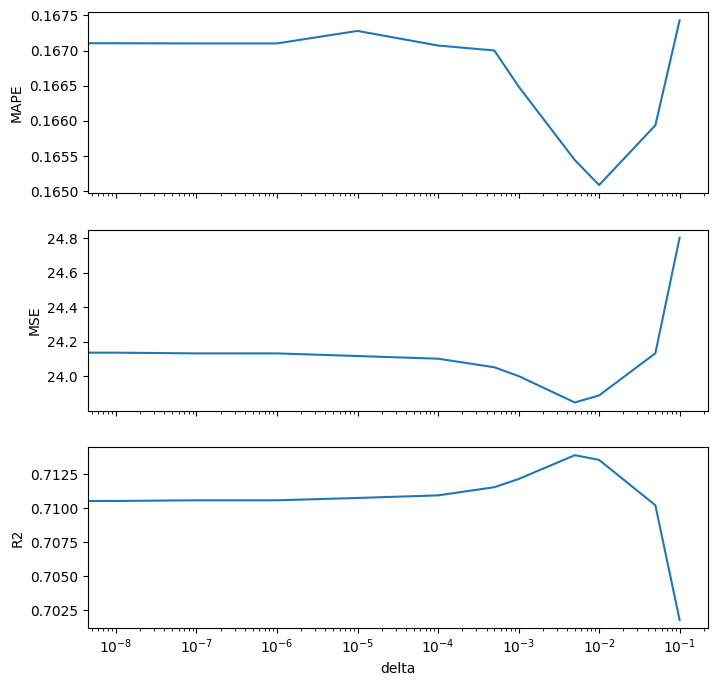

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
ax[0].plot(deltas, mapes)
ax[1].plot(deltas, mses)
ax[2].plot(deltas, r2s)
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('MSE')
ax[2].set_ylabel('R2')
plt.xlabel('delta')
plt.xscale('log')
plt.show()

### Compare different models

In [16]:
results = pd.DataFrame(RESULT_METRICS)
results

,name,mape,mse,r2
0,Linear Regression,0.173598,23.997703,0.711753
1,RANSAC,0.199865,27.526675,0.667646
2,Huber Regressor,0.166953,23.815054,0.714309
3,Robust LR,0.165441,23.848790,0.713888
